# Problem Statement: #

HELP International have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. So, CEO has to make decision to choose the countries that are in the direst need of aid. Hence, your Job as a Data scientist is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.

In [1]:
# import libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None) # display full width without truncation on dataframes

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from  matplotlib.ticker import PercentFormatter #for formatting the y axis on plots into percentages

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Import datasets

ds = pd.read_csv("Country-data.csv")
dd = pd.read_csv("data-dictionary.csv")

# Data Dictionary

In [3]:
dd.head(10)

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 1000 live births
2,exports,Exports of goods and services per capita. Given as %age of the GDP per capita
3,health,Total health spending per capita. Given as %age of GDP per capita
4,imports,Imports of goods and services per capita. Given as %age of the GDP per capita
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of the Total GDP
7,life_expec,The average number of years a new born child would live if the current mortality patterns are to remain the same
8,total_fer,The number of children that would be born to each woman if the current age-fertility rates remain the same.
9,gdpp,The GDP per capita. Calculated as the Total GDP divided by the total population.


# Process

1) Exploratory data analysis - outliers/scaling
2) Correlation
3) PCA

In [4]:
ds.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
# Check for null values
ds.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [6]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [7]:
ds.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


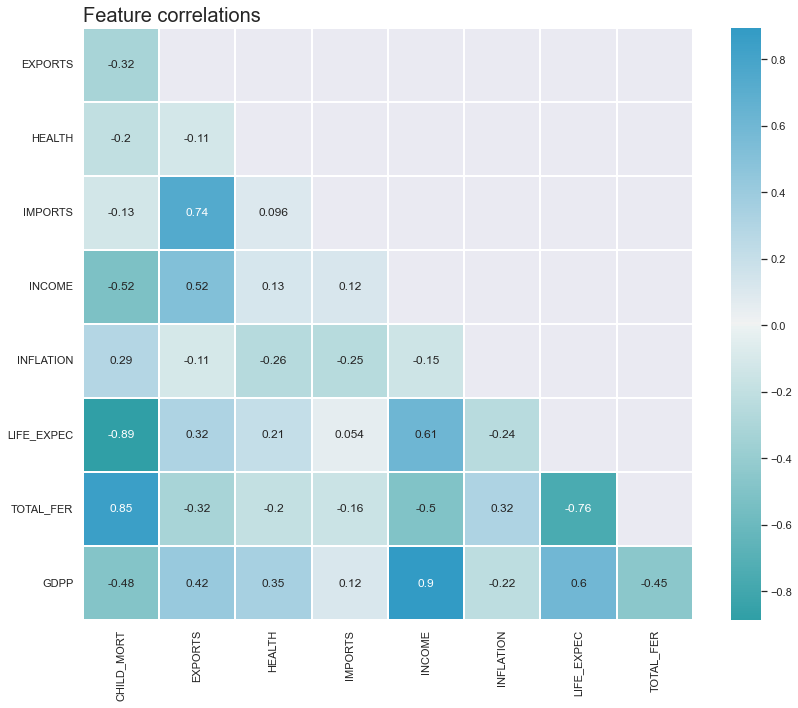

In [8]:
#Plot correlation matrix

plt.rcParams["figure.figsize"] = [12, 10]
plt.rcParams["figure.autolayout"] = True

#create a mask to show only only the upper triangle

cors = np.ones_like(ds.corr(), dtype=bool)
mask = np.triu(cors)

# adjust mask and df to ommit the empty cells
mask = mask[1:, :-1]
df_corr = ds.corr().iloc[1:,:-1]

#Create diverging palette
cmap = sns.diverging_palette(200, 230, 90, 60, as_cmap=True)

sns.heatmap(df_corr, annot=True, cmap=cmap, linewidth=0.4, mask=mask)
plt.title("Feature correlations", loc="left", fontsize = 20)
yticks = [i.upper() for i in df_corr.index]
xticks = [i.upper() for i in df_corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks,rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks, rotation=90)
plt.show()

In [9]:
#Scale the data

ds_numeric = ds.iloc[:,1:] #remove the country feature to keep only the numeric columns

scaler = StandardScaler()
ds_scaled = scaler.fit_transform(ds_numeric)
ds_scaled.shape

(167, 9)

In [10]:
# PCA

pca = PCA(n_components=9)
ds_pca = pca.fit_transform(ds_scaled)
ds_pca = pd.DataFrame(ds_pca)
ds_pca

,0,1,2,3,4,5,6,7,8
0,-2.913025,0.095621,-0.718118,1.005255,-0.158310,-0.254597,0.383000,0.415076,-0.014148
1,0.429911,-0.588156,-0.333486,-1.161059,0.174677,0.084579,0.248919,-0.221042,0.173316
2,-0.285225,-0.455174,1.221505,-0.868115,0.156475,-0.401696,-0.087214,-0.184162,0.084037
3,-2.932423,1.695555,1.525044,0.839625,-0.273209,-0.547996,-0.440835,-0.355998,-0.091339
4,1.033576,0.136659,-0.225721,-0.847063,-0.193007,-0.206919,0.241978,-0.023681,0.094270
...,...,...,...,...,...,...,...,...,...
162,-0.820631,0.639570,-0.389923,-0.706595,-0.395748,0.009059,-0.098738,0.521886,-0.497803
163,-0.551036,-1.233886,3.101350,-0.115311,2.082581,0.097274,0.206735,-0.078805,-0.275735
164,0.498524,1.390744,-0.238526,-1.074098,1.176081,0.051607,-0.143627,-0.217590,-0.036522
165,-1.887451,-0.109453,1.109752,0.056257,0.618365,-0.540917,0.060256,0.089495,-0.096049


In [11]:
print(f'Sum of explained variance: {sum(pca.explained_variance_ratio_)}')
print(np.cumsum(pca.explained_variance_ratio_))

Sum of explained variance: 1.0
[0.4595174  0.63133365 0.76137624 0.87190786 0.94530998 0.97015232
 0.98275663 0.99256944 1.        ]


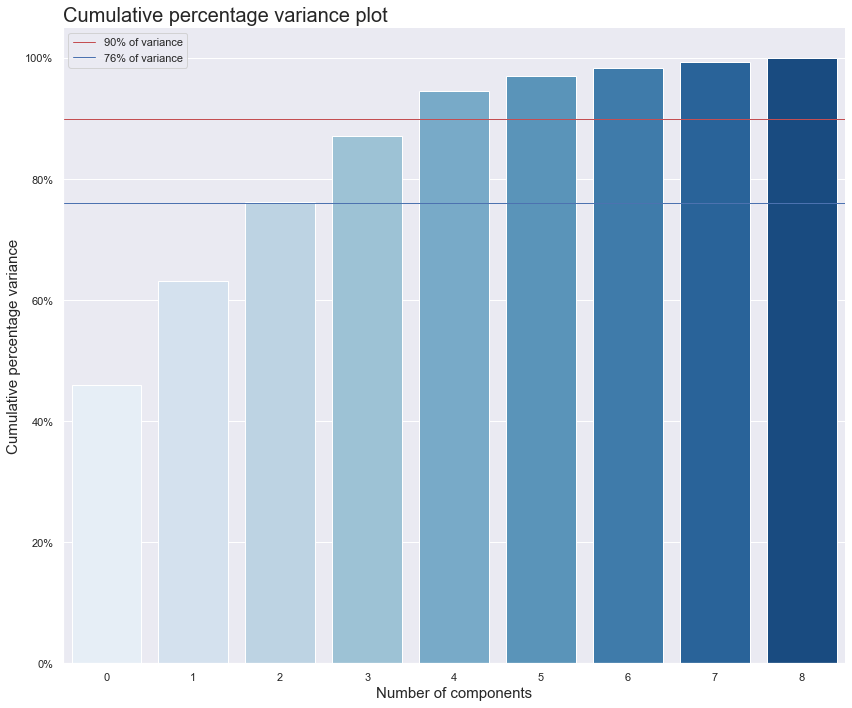

In [12]:
#create

c = sns.barplot(x=ds_pca.columns, y=np.cumsum(pca.explained_variance_ratio_), palette = "Blues")
plt.title("Cumulative percentage variance plot", loc="left", fontsize=20)
plt.ylabel('Cumulative percentage variance', fontsize=15)
plt.xlabel('Number of components' , fontsize=15)
c.yaxis.set_major_formatter(PercentFormatter(1))
plt.axhline(y=0.9, linewidth=1, label= '90% of variance', color='r')
plt.axhline(y=0.76, linewidth=1, label= '76% of variance')
plt.legend(loc = 'upper left')
sns.set_style("dark")
sns.despine()
plt.show()




The first 5 components contain 94% of the variance, the first three capture around 76%

In [13]:
# Now run the PCA on 5 components

pca3 = PCA(n_components=5)
ds_pca3 = pca3.fit_transform(ds_scaled)
ds_pca3 = pd.DataFrame(ds_pca3)
ds_pca3.columns = ['P1', 'P2', 'P3', 'P4', 'P5']

print(np.cumsum(pca3.explained_variance_ratio_))

[0.4595174  0.63133365 0.76137624 0.87190786 0.94530998]


In [14]:
#Create a dictionary to rename the row names to match the original dataset
x = list(range(0,9))
y = dict(zip(x, ds_numeric.columns.values))
print(y)

{0: 'child_mort', 1: 'exports', 2: 'health', 3: 'imports', 4: 'income', 5: 'inflation', 6: 'life_expec', 7: 'total_fer', 8: 'gdpp'}


In [15]:
#Create a dataset to show amount of variance for each feature in each component
ds_expl_var = pd.DataFrame(data=pca3.components_.transpose())
ds_expl_var.columns = ['P1', 'P2', 'P3', 'P4', 'P5']
ds_expl_var.rename(index=y, inplace=True)
ds_expl_var

,P1,P2,P3,P4,P5
child_mort,-0.419519,0.192884,-0.029544,0.370653,-0.168970
exports,0.283897,0.613163,0.144761,0.003091,0.057616
health,0.150838,-0.243087,-0.596632,0.461897,0.518000
imports,0.161482,0.671821,-0.299927,-0.071907,0.255376
income,0.398441,0.022536,0.301548,0.392159,-0.247150
inflation,-0.193173,-0.008404,0.642520,0.150442,0.714869
life_expec,0.425839,-0.222707,0.113919,-0.203797,0.108220
total_fer,-0.403729,0.155233,0.019549,0.378304,-0.135262
gdpp,0.392645,-0.046022,0.122977,0.531995,-0.180167


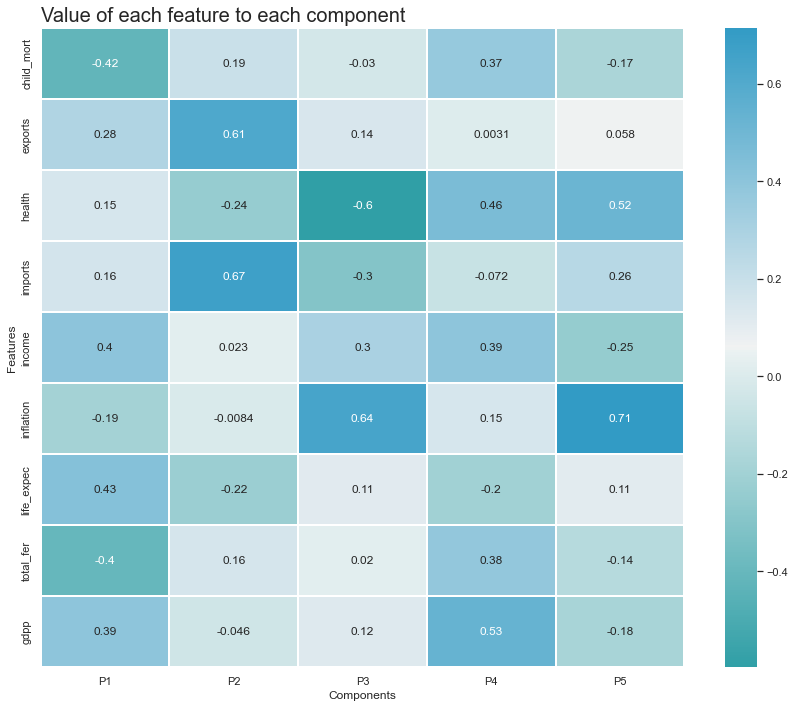

In [16]:
sns.heatmap(ds_expl_var, annot=True, cmap = cmap, linewidth=0.4)
plt.title("Value of each feature to each component", loc="left", fontsize=20)
plt.ylabel("Features")
plt.xlabel("Components")
plt.show()

#Create diverging palette
cmap = sns.diverging_palette(200, 230, 90, 60, as_cmap=True)



# Try basic K-means

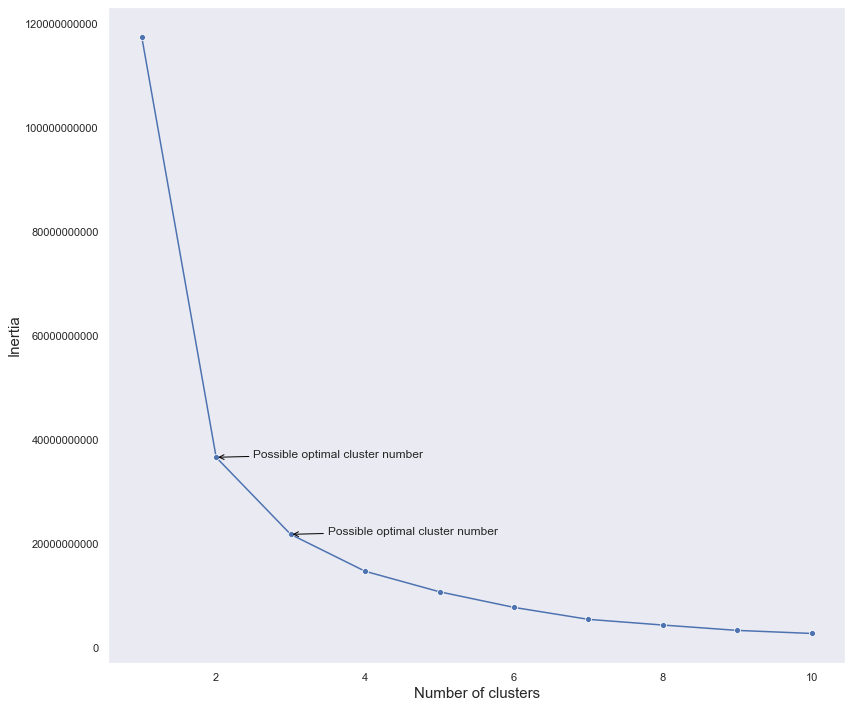

In [17]:
# use the elbow method to work out the optimum number of clusters to use in the k means model

num_clusters = [1,2,3,4,5,6,7,8,9,10]

# Create models for each number in the list
kmeans_list = [KMeans(n_clusters = i) for i in num_clusters] 

model_scores = [kmeans_list[i-1].fit(ds_numeric).inertia_ for i in num_clusters]

# Plot the scores

sns.lineplot(x=num_clusters, y=model_scores, palette = "Blues", marker = 'o')
plt.xlabel("Number of clusters", fontsize=15)
plt.ylabel("Inertia", fontsize=15)
# plt.title("Elbow method for cluster number selection", fontsize =20, loc="left")
plt.annotate("Possible optimal cluster number", xy=(2, kmeans_list[1].inertia_), xycoords='data', 
            xytext=(2.5, kmeans_list[1].inertia_+0.5),
            arrowprops=dict(arrowstyle='->', color='black'))
plt.annotate("Possible optimal cluster number", xy=(3, kmeans_list[2].inertia_), xycoords='data', 
            xytext=(3.5, kmeans_list[2].inertia_+0.5),
            arrowprops=dict(arrowstyle='->', color='black'))
plt.ticklabel_format(style='plain')
plt.show()



It is not completely clear which cluster is optimal here - could be 2 or 3. Let's make double sure with checking the silhouette score:


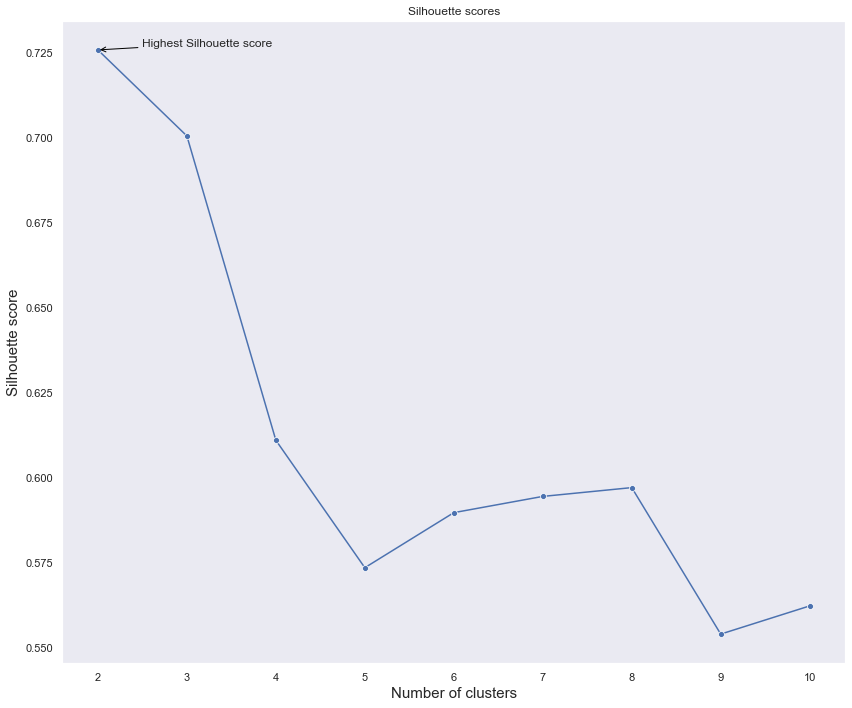

In [18]:
silhouette_scores=[]
n_clust = []

for clust in range(2, 11):
    n_clust.append(clust)
    silhouette_scores.append(silhouette_score(ds_numeric, 
                                              KMeans(n_clusters=clust, random_state=123).fit_predict(ds_numeric)))
    
# Plot the scores

sns.lineplot(x=n_clust, y=silhouette_scores, palette = "Blues", marker = 'o')
plt.xlabel("Number of clusters", fontsize=15)
plt.ylabel("Silhouette score", fontsize=15)
plt.annotate(xy = (2,silhouette_scores[0]), text="Highest Silhouette score", xycoords='data',
             xytext=(2.5, silhouette_scores[0]+0.001),
            arrowprops=dict(arrowstyle="->", color='black'))
plt.title("Silhouette scores")
plt.show()

Run the model with 2 clusters:

In [19]:
model = KMeans(n_clusters=2, random_state=123)
model.fit(ds_numeric)

KMeans(n_clusters=2, random_state=123)

In [20]:
# Add a new column to the original dataset
ds['Cluster'] = model.labels_
ds

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,0
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,0
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,0
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,0
